<a href="https://colab.research.google.com/github/naoya5614/Practice/blob/main/Edit_gasyori100knock_09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 画像処理100本ノック(80~90問)

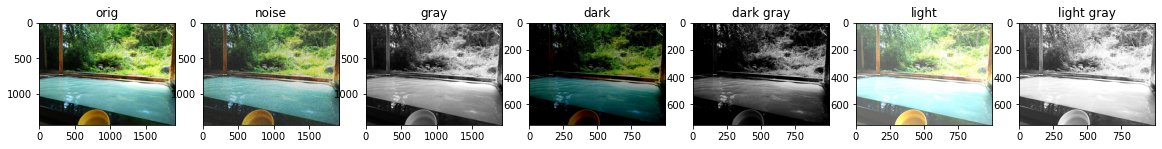

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import io

img_orig = io.imread('https://github.com/naoya5614/Practice/blob/main/img/sample05.jpg?raw=true')
img_128 = io.imread('https://github.com/naoya5614/Practice/blob/main/img/sample09.png?raw=true')
img_gray_128 = cv2.cvtColor(img_128, cv2.COLOR_RGB2GRAY)
img_noise = io.imread('https://github.com/naoya5614/Practice/blob/main/img/sample06.jpg?raw=true')
img_gray = cv2.cvtColor(img_orig, cv2.COLOR_RGB2GRAY)
img_dark = io.imread('https://github.com/naoya5614/Practice/blob/main/img/sample07.jpg?raw=true')
img_dark_gray = cv2.cvtColor(img_dark, cv2.COLOR_RGB2GRAY)
img_light = io.imread('https://github.com/naoya5614/Practice/blob/main/img/sample08.jpg?raw=true')
img_light_gray = cv2.cvtColor(img_light, cv2.COLOR_RGB2GRAY)
img_thorino = io.imread('https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/thorino.jpg')
img_thorino_gray = cv2.cvtColor(img_thorino, cv2.COLOR_RGB2GRAY)

img_eye = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/imori_256x256_eye.png")
img_eye = cv2.cvtColor(img_eye, cv2.COLOR_RGBA2RGB)

img_seg = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/seg_sample.png")
img_connect = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/connect_sample.png")
img_gazo = io.imread("https://yoyoyo-yo.github.io/Gasyori100knock/dataset/images/gazo_sample.png")

plt.figure(figsize=(20, 4))
plt.subplot(1, 7, 1); plt.imshow(img_orig); plt.title('orig')
plt.subplot(1, 7, 2); plt.imshow(img_noise); plt.title('noise')
plt.subplot(1, 7, 3); plt.imshow(img_gray, cmap='gray'); plt.title('gray')
plt.subplot(1, 7, 4); plt.imshow(img_dark);  plt.title('dark')
plt.subplot(1, 7, 5); plt.imshow(img_dark_gray, cmap='gray'); plt.title('dark gray')
plt.subplot(1, 7, 6); plt.imshow(img_light);  plt.title('light')
plt.subplot(1, 7, 7); plt.imshow(img_light_gray, cmap='gray'); plt.title('light gray')
plt.show()

## Q.81 Hessianのコーナー検出

thorino.jpgにHessian(ヘシアン)のコーナー検出を行え。

コーナー検出とはエッジにおける角の点を検出することである。

コーナーは曲率が大きくなる点であり、次式のガウス曲率において、

```
ガウス曲率 K = det(H) / (1 + Ix^2 + Iy^2)^2

det(H) = Ixx Iyy - IxIy^2
H ... ヘシアン行列。画像の二次微分(グレースケール画像などに対して、Sobelフィルタを掛けて求められる)。画像上の一点に対して、次式で定義される。
Ix ... x方向のsobelフィルタを掛けたもの。 
Iy ... y方向のsobelフィルタを掛けたもの。
H = [ Ix^2  IxIy]
      IxIy  Iy^2
```
ヘシアンのコーナー検出では、det(H)が極大点をコーナーとみなす。 極大点は注目画素と8近傍を比較して、注目画素の値が最大であれば極大点として扱う。

解答ではdet(H)が極大点かつ、max(det(H))*0.1を超過する点をコーナーとしている。

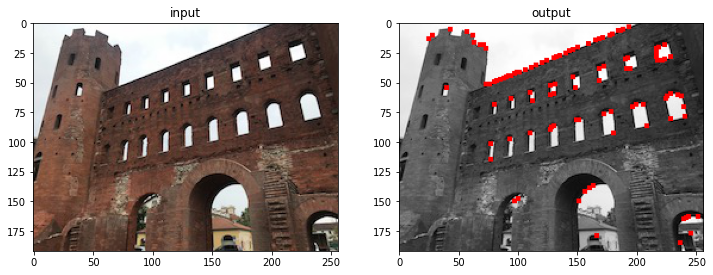

In [6]:
def hessian_corner(gray):

    ## Sobel
    def sobel_filtering(gray):
        # get shape
        H, W = gray.shape

        # sobel kernel
        sobely = np.array(((1, 2, 1),
                        (0, 0, 0),
                        (-1, -2, -1)), dtype=np.float32)

        sobelx = np.array(((1, 0, -1),
                        (2, 0, -2),
                        (1, 0, -1)), dtype=np.float32)

        # padding
        tmp = np.pad(gray, (1, 1), 'edge')

        # prepare
        Ix = np.zeros_like(gray, dtype=np.float32)
        Iy = np.zeros_like(gray, dtype=np.float32)

        # get differential
        for y in range(H):
            for x in range(W):
                Ix[y, x] = np.mean(tmp[y : y  + 3, x : x + 3] * sobelx)
                Iy[y, x] = np.mean(tmp[y : y + 3, x : x + 3] * sobely)

        Ix2 = Ix ** 2
        Iy2 = Iy ** 2
        Ixy = Ix * Iy

        return Ix2, Iy2, Ixy

    ## Hessian
    def corner_detect(gray, Ix2, Iy2, Ixy, pad=2):
        # get shape
        H, W = gray.shape

        # prepare for show detection
        out = np.array((gray, gray, gray))
        out = np.transpose(out, (1,2,0))

        # get Hessian value
        Hes = np.zeros((H, W))

        for y in range(H):
            for x in range(W):
                Hes[y,x] = Ix2[y,x] * Iy2[y,x] - Ixy[y,x] ** 2

        ## Detect Corner and show
        for y in range(H):
            for x in range(W):
                if Hes[y,x] == np.max(Hes[max(y-1, 0) : min(y+2, H), max(x-1, 0) : min(x+2, W)]) and Hes[y, x] > np.max(Hes) * 0.1:
                    out[y - pad : y + pad, x - pad : x + pad] = [255, 0, 0]

        out = out.astype(np.uint8)

        return out

    #  image sobel
    Ix2, Iy2, Ixy = sobel_filtering(gray)

    # corner detection
    out = corner_detect(gray, Ix2, Iy2, Ixy)

    return out

img_thorino_hessian = hessian_corner(img_thorino_gray)

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].set_title("input")
ax[0].imshow(img_thorino, cmap="gray")
ax[1].set_title("output")
ax[1].imshow(img_thorino_hessian, cmap="gray")
plt.show()

## Q.82 Harrisのコーナー検出 (Step.1) Sobel + Gauusian

ここからQ.83までthorino.jpgにHarris(ハリス)のコーナー検出を行っていく。

Harrisのコーナー検出のアルゴリズムは、

グレースケールに対して、Sobelフィルタにより、ヘシアン行列を求める。

```
H = [ Ix^2  IxIy]
      IxIy  Iy^2
```

*   Ix^2, Iy^2, IxIyにそれぞれガウシアンフィルターをかける。
*   各ピクセル毎に、R = det(H) - k (trace(H))^2 を計算する。 (kは実験的に0.04 - 0.06らへんが良いとされる)
*   R >= max(R) * th を満たすピクセルがコーナーとなる。 (thは0.1となることが多い)

Q.82-83においての各パラメータは以下の通り。

ガウシアンフィルター(k=3, sigma=3) k = 0.04, th = 0.1 ここでは1-3までを実装せよ。

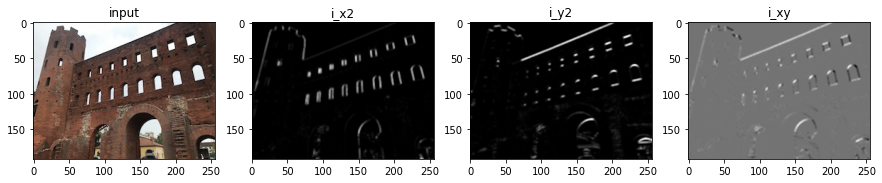

In [7]:
def Sobel_filtering(gray):
    # get shape
    H, W = gray.shape

    # sobel kernel
    sobely = np.array(((1, 2, 1),
                    (0, 0, 0),
                    (-1, -2, -1)), dtype=np.float32)

    sobelx = np.array(((1, 0, -1),
                    (2, 0, -2),
                    (1, 0, -1)), dtype=np.float32)

    # padding
    tmp = np.pad(gray, (1, 1), 'edge')

    # prepare
    Ix = np.zeros_like(gray, dtype=np.float32)
    Iy = np.zeros_like(gray, dtype=np.float32)

    # get differential
    for y in range(H):
        for x in range(W):
            Ix[y, x] = np.mean(tmp[y : y  + 3, x : x + 3] * sobelx)
            Iy[y, x] = np.mean(tmp[y : y + 3, x : x + 3] * sobely)

    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy

    return Ix2, Iy2, Ixy


# gaussian filtering
def gaussian_filtering(I, K_size=3, sigma=3):
    # get shape
    H, W = I.shape

    ## gaussian
    I_t = np.pad(I, (K_size // 2, K_size // 2), 'edge')

    # gaussian kernel
    K = np.zeros((K_size, K_size), dtype=np.float32)
    for x in range(K_size):
        for y in range(K_size):
            _x = x - K_size // 2
            _y = y - K_size // 2
            K[y, x] = np.exp( -(_x ** 2 + _y ** 2) / (2 * (sigma ** 2)))
    K /= (sigma * np.sqrt(2 * np.pi))
    K /= K.sum()

    # filtering
    for y in range(H):
        for x in range(W):
            I[y,x] = np.sum(I_t[y : y + K_size, x : x + K_size] * K)

    return I


# get difference image
i_x2, i_y2, i_xy = Sobel_filtering(img_thorino_gray)

# gaussian filtering
i_x2 = gaussian_filtering(i_x2, K_size=3, sigma=3)
i_y2 = gaussian_filtering(i_y2, K_size=3, sigma=3)
i_xy = gaussian_filtering(i_xy, K_size=3, sigma=3)


fig, ax = plt.subplots(1, 4, figsize=(15, 3))
ax[0].set_title("input")
ax[0].imshow(img_thorino, cmap="gray")
ax[1].set_title("i_x2")
ax[1].imshow(i_x2, cmap="gray")
ax[2].set_title("i_y2")
ax[2].imshow(i_y2, cmap="gray")
ax[3].set_title("i_xy")
ax[3].imshow(i_xy, cmap="gray")
plt.show()

## Q.83 Harrisのコーナー検出 (Step.2) コーナー検出

ここではアルゴリズム4-5を実装せよ。

4における k = 0.04、5におけるth = 0.1

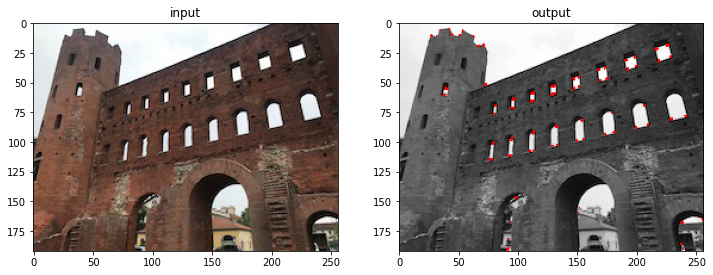

In [8]:
def corner_detect(gray, Ix2, Iy2, Ixy, k=0.04, th=0.1):
    # prepare output image
    out = np.array((gray, gray, gray))
    out = np.transpose(out, (1,2,0))

    # get R
    R = (Ix2 * Iy2 - Ixy ** 2) - k * ((Ix2 + Iy2) ** 2)

    # detect corner
    out[R >= np.max(R) * th] = [255, 0, 0]

    out = out.astype(np.uint8)

    return out

out = corner_detect(img_thorino_gray, i_x2, i_y2, i_xy)

fig, ax = plt.subplots(1, 2, figsize=(12, 12))
ax[0].set_title("input")
ax[0].imshow(img_thorino, cmap="gray")
ax[1].set_title("output")
ax[1].imshow(out, cmap="gray")
plt.show()

## Q.84 簡単な画像認識 (Step.1) 減色化 + ヒストグラム

ここでは簡単な画像認識を作成する。

画像認識とは画像に写っているモノが何か（どのクラスに属するか）を特定するタスクである。 画像認識はよく、画像分類、Classification(クラス分類)、Categorization(カテゴライゼーション)、Clustering(クラスタリング)、などと呼ばれる。

よくある手法は画像から何らかの特徴(HOGやSIFT, SURFなど)を抽出し、その特徴によりクラスを判別する。 CNNが流行る以前はこのアプローチがよく取られたが、CNNは特徴抽出から判別までを一括して行える。

ここでは、画像の色ヒストグラムを用いた簡単な画像認識を行う。

アルゴリズムとしては、

*   画像(train_@@@.jpg)をリサイズし、減色処理(Q.6. RGBをそれぞれ4階調)する。
*   減色処理した画像のヒストグラムを作成する。ここでのヒストグラムはRGBがそれぞれ4値をとるが、それらを区別するため、B=[1,4], G=[5,8], R=[9,12]のbin=12となる。それぞれの画像に対応するヒストグラムも保存する必要があるので注意。 　つまり、database = np.zeros((10(学習データ数), 13(RGB + class), dtype=np.int)　に学習データのヒストグラムを格納する必要がある。
*   ヒストグラムをデータベースとする。

認識したい画像(test_@@@.jpg)とヒストグラムの差を計算して、特徴量とする。 ヒストグラムの差の合計で、最小となった画像が予測となるクラスである。つまり、色が近い画像と同じクラスになると考えられる。 ここでは1-3を実装し、ヒストグラムを可視化せよ。 学習データはdatasetフォルダにあり train_akahara_@@@.jpg (クラス1)と train_madara_@@@.jpg(クラス2) を用いる。(計10枚) akaharaとはアカハライモリ、madaraはマダライモリである。

このような予め特徴量を保存しておくデータベース型は人工知能第一世代の手法である。ようは、全部のパターンを暗記しておけばOKという考え方である。ただし、そうするとメモリを大量に消費するので使用が限られる手法である。


https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_1.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_2.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_3.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_1.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_2.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_3.jpg


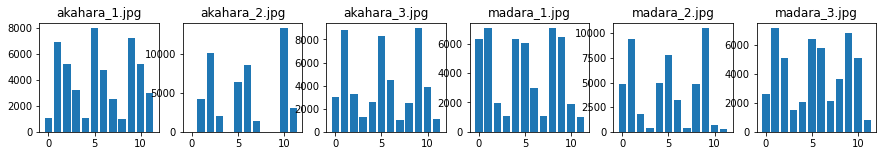

In [10]:
# dicrease color
def dic_color(img):
    img = img // 64 * 64 + 32
    return img

def get_feature(img):
    feat = np.zeros(12, dtype=np.float32)
    
    for i in range(4):
        feat[i,] = (img[..., 0] == (64 * i + 32)).sum() #len(np.where(img[..., 0] == (64 * j + 32))[0])
        feat[i + 4] = (img[..., 1] == (64 * i + 32)).sum()
        feat[i + 8] = (img[..., 2] == (64 * i + 32)).sum()
        
    return feat

# database
def get_db():
    train_paths = [
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_3.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_3.jpg"
    ]
    
    # prepare database
    db = np.zeros((len(train_paths), 13), dtype=np.float32)

    # each image
    for i, path in enumerate(train_paths):
        print(path)
        img = io.imread(path)
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
        img = dic_color(img)
        feat = get_feature(img)
        db[i, :-1] = feat

        # get class
        if 'akahara' in path:
            cls = 0
        elif 'madara' in path:
            cls = 1

        # store class label
        db[i, -1] = cls

    return db, train_paths

# get database
db, train_paths = get_db()

fig, ax = plt.subplots(1, 6, figsize=(15, 2))

for i in range(len(db)):
    ax[i].set_title(train_paths[i].split("/")[-1])
    ax[i].bar(np.arange(12), db[i, :-1])
    
plt.show()

## Q.85 簡単な画像認識 (Step.2) クラス判別

ここではアルゴリズム4-5を実装せよ。

テストデータには akahara_@@@.jpgと madara_@@@.jpgを用いよ。 ただし、各画像と最もヒストグラム差分が小さい画像の名前と予測クラスの2つを出力せよ。

これはNearesetNeighborと呼ばれる評価方法である。

In [11]:
test_paths = [
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_3.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_3.jpg"
    ]

for path in test_paths:
    img = io.imread(path)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
    img = dic_color(img)
    feat = get_feature(img)

    db_diff = np.abs(db[:, :-1] - feat)
    distances = db_diff.sum(axis=1)
    nearest = distances.argmin()
    pred_cls = db[nearest, -1]
    label = "akahara" if pred_cls == 0 else "madara"
    
    print(path.split("/")[-1], ", pred >>", label)

akahara_1.jpg , pred >> akahara
akahara_2.jpg , pred >> akahara
akahara_3.jpg , pred >> akahara
madara_1.jpg , pred >> madara
madara_2.jpg , pred >> madara
madara_3.jpg , pred >> madara


## Q.86 簡単な画像認識 (Step.3) 評価(Accuracy)

ここでは画像認識の結果を評価する。

画像認識の場合はどれくらい正解クラスを予想できたかを示すAccuracy(Precisionといったりもする)が一般的な評価指標である。Accuracyは次式で計算される。要はテストにおける得点率である。小数表示するときや、100掛けてパーセンテージで表すこともある。

```
Accuracy = (正解した画像数) / (テストした画像の総数)
```
以上を踏まえて、Q.85のAccuracyを求めよ。

In [12]:
accuracy = 6 / 6
accuracy

1.0

## Q.87 簡単な画像認識 (Step.4) k-NN


Q.85ではmadara_2.jpgがアカハライモリと予測された。

これを回避するために、ここでは色合いが近い画像を3つ選び、それらの多数決によって予測クラスを決定する。

このように特徴が近いものを学習データからk個選んで判断する手法をk近傍(k-NN: k-Nearest Neighbor)という。Q.85.のNN法はk=1の場合とみれる。

In [13]:
k = 3

from collections import Counter

for path in test_paths:
    img = io.imread(path)
    img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
    img = dic_color(img)
    feat = get_feature(img)

    db_diff = np.abs(db[:, :-1] - feat)
    distances = db_diff.sum(axis=1)
    nearest = distances.argsort()[:k]
    pred_cls = db[nearest, -1]
    
    counts = Counter(pred_cls).most_common()
    label = "akahara" if counts[0][0] == 0 else "madara"
    
    print(path.split("/")[-1], ", pred >>", label)

akahara_1.jpg , pred >> akahara
akahara_2.jpg , pred >> akahara
akahara_3.jpg , pred >> akahara
madara_1.jpg , pred >> madara
madara_2.jpg , pred >> madara
madara_3.jpg , pred >> madara


## Q.88 K-means (Step.1) 重心作成

Q.84-87の画像認識は教師データを必要とするいわゆる教師あり学習(supervised-training)のものすごく簡単なものだったが、ここでは教師を必要としない教師なし学習(unsupervised-training)で画像を分類する。

最も簡単な方法がK-meansクラスタリング法である。

これは予めクラス数が分かっている場合に使うことができ、特徴量を重心に分けながらクラスタリングする手法である。

K-Meansアルゴリズムとしては、

1.   データにそれぞれランダムにクラスを割り当てる。
2.   クラスごとに重心を計算する。
3.   各データと重心の距離を計算し、最も距離が近い重心のクラスを割り当てる。
4.   2-3をクラス変更がなくなるまで繰り返す。

ここでは、trainの画像に対して次のように行う。

1.   画像を減色化し、ヒストグラムを作成し、これを特徴量とする。
2.   各画像にランダムに0か1のクラスを割り当てる。 (ここでは、クラス数=2, np.random.seed(1)　として、np.random.random() < thなら0、>= thなら1を割り当てる。th=0.5)
3.   クラスが0、１の特徴量の重心(mean)をそれぞれ取る。(重心は gs = np.zeros((Class, 12), dtype=np.float32)に格納する。)
4.   各画像に対して、特徴量と重心の距離(ユークリッド距離(L1ノルム): 差を二乗し、その合計のsqrtをとったもの)を計算し、距離が近い重心のクラスを割り当てる。
5.   3-4をクラスの変更がなくなるまで繰り返す。

ここでは、1-3までを実装せよ(4,5のことを考えてループを作らなくてもよい)。


In [14]:
def assign_label_init(db, paths, class_n=2):
    feats = db.copy()

    # assign random label
    np.random.seed(0)
    feats[:, -1] = np.random.randint(0, class_n, (len(db)))

    # prepare gravity
    gs = np.zeros((class_n, feats.shape[1] - 1), dtype=np.float32)
        
    # get gravity
    for i in range(class_n):
        gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :12], axis=0)
        
    print("assigned label")
    print(feats[:, -1])
    print("Grabity")
    print(gs)
    
assign_label_init(db, train_paths)

assigned label
[0. 1. 1. 0. 1. 1.]
Grabity
[[3672.   6966.5  3608.5  2137.   3705.5  7019.   3861.   1798.5  3995.5
  6821.   3549.5  2018.  ]
 [2610.75 7386.75 5080.   1306.5  2404.5  7202.25 5537.   1240.25 2752.
  6570.5  5746.75 1314.75]]


## Q.89 K-means (Step.2) クラスタリング

ここではアルゴリズム4-5も実装して、クラスタリングを行え。

ここで予測クラスが0,1となっているが、Q.85-87と違いラベルの順番はバラバラである。 なので、K-meansはあくまでカテゴリ別に分類する手法であり、それが具体的に何のクラスかまでは分からない。 また、クラス数は予めこちらが知って置かなければいけない。

K-meansクラスタリングでは最初に割り当てるラベルの状態によって、最後の出力が大きく左右されるので注意が必要である。 また、データ数が少ないと失敗しやすい。これはデータ数が少ないことで、真のデータの分布をサンプリングしにくいことが原因である。つまり、データ数が多いほどデータの分布が精度良くえられることによる。

In [15]:
def label_kmeans(db, paths, class_n=2):
    feats = db.copy()
    feat_n = feats.shape[1] - 1
    
    # assign random label
    np.random.seed(0)
    feats[:, -1] = np.random.randint(0, class_n, (len(db)))

    # prepare gravity
    gs = np.zeros((class_n, feat_n), dtype=np.float32)
        
    # get gravity
    for i in range(class_n):
        gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :feat_n], axis=0)

    while True:
        # prepare greavity
        gs = np.zeros((class_n, feat_n), dtype=np.float32)
        change_count = 0

        # compute gravity
        for i in range(class_n):
            gs[i] = np.mean(feats[np.where(feats[..., -1] == i)[0], :feat_n], axis=0)

        # re-labeling
        for i in range(len(feats)):
            # get distance each nearest graviry
            dis = np.sqrt(np.sum(np.square(np.abs(gs - feats[i, :feat_n])), axis=1))

            # get new label
            pred = np.argmin(dis, axis=0)

            # if label is difference from old label
            if int(feats[i, -1]) != pred:
                change_count += 1
                feats[i, -1] = pred

        if change_count < 1:
            break

    for i in range(db.shape[0]):
        print(paths[i].split("/")[-1], " Pred:", feats[i, -1])
        
label_kmeans(db, train_paths)

akahara_1.jpg  Pred: 1.0
akahara_2.jpg  Pred: 1.0
akahara_3.jpg  Pred: 0.0
madara_1.jpg  Pred: 0.0
madara_2.jpg  Pred: 0.0
madara_3.jpg  Pred: 1.0


## Q.90 K-means データを増やす

testの画像も加えてkmeansを行え。

In [16]:
def get_db_all():
    train_paths = [
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_3.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_3.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_3.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_1.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_2.jpg",
        "https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_3.jpg"
    ]
    
    # prepare database
    db = np.zeros((len(train_paths), 13), dtype=np.float32)

    # each image
    for i, path in enumerate(train_paths):
        print(path)
        img = io.imread(path)
        img = cv2.resize(img, (128, 128), interpolation=cv2.INTER_CUBIC)
        img = dic_color(img)
        feat = get_feature(img)
        db[i, :-1] = feat

        # get class
        if 'akahara' in path:
            cls = 0
        elif 'madara' in path:
            cls = 1

        # store class label
        db[i, -1] = cls

    return db, train_paths

db2, train_paths2 = get_db_all()

print("\nkmeans")
label_kmeans(db2, train_paths2)

https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_1.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_2.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/akahara_3.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_1.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_2.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/train/madara_3.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_1.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_2.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/akahara_3.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_1.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_2.jpg
https://yoyoyo-yo.github.io/Gasyori100knock/dataset/test/madara_3.jpg

kmeans
akahara_1.jpg  Pred: 1.0
akahara_2.jpg  Pred: 1.0
akahara_3.jpg  Pred: 0.0
madara_1.jpg  Pred: 0.0
madara_2.jpg  Pred: 0.0
madara_3.jpg  Pre